## One-time installs

In [0]:
!nvidia-smi

#### NVIDIA Apex

In [2]:
!git clone https://github.com/NVIDIA/apex
% cd apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
% cd /content

Cloning into 'apex'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 4794 (delta 81), reused 109 (delta 60), pack-reused 4636
Receiving objects: 100% (4794/4794), 8.79 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (3093/3093), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-xjrr4510
Created temporary directory: /tmp/pip-req-tracker-2q6ugfkj
Created requirements tracker '/tmp/pip-req-tracker-2q6ugfkj'
Created temporary directory: /tmp/pip-install-74d2whrb
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-daxtm_ay
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-2q6ugfkj'
  

#### BERT pretrained model repo (contains module for OpenAI GPT)

In [3]:
! git clone https://github.com/epsdg/pytorch-pretrained-BERT

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

! pip install regex

Cloning into 'pytorch-pretrained-BERT'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 3993 (delta 28), reused 29 (delta 15), pack-reused 3939
Receiving objects: 100% (3993/3993), 2.20 MiB | 3.86 MiB/s, done.
Resolving deltas: 100% (2760/2760), done.
     |████████████████████████████████| 655kB 9.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


#### Pretrained model data

In [0]:
import shutil
shutil.rmtree('/content/models/gpt')
shutil.rmtree('/content/finetune-transformer-lm')
shutil.rmtree('/content/pytorch-openai-transformer-lm')

In [9]:
import os
os.makedirs('/content/models/gpt')

# original model from the openai repo
! git clone https://github.com/openai/finetune-transformer-lm
! cp /content/finetune-transformer-lm/model/* /content/models/gpt/

# parameters_names.json from the huggingface port
! git clone https://github.com/huggingface/pytorch-openai-transformer-lm
! cp /content/pytorch-openai-transformer-lm/parameters_names.json /content/models/gpt/

# pretrained pytorch model and config.json
! curl https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-config.json --output '/content/models/gpt/config.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-pytorch_model.bin --output '/content/models/gpt/pytorch_model.bin'

# vocab and merges files for the pretrained OpenAIGPTTokenizer
! curl https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-vocab.json --output '/content/models/gpt/vocab.json'
! curl https://s3.amazonaws.com/models.huggingface.co/bert/openai-gpt-merges.txt --output '/content/models/gpt/merges.txt'

Cloning into 'finetune-transformer-lm'...
remote: Enumerating objects: 38, done.
remote: Total 38 (delta 0), reused 0 (delta 0), pack-reused 38
Unpacking objects: 100% (38/38), done.
Checking out files: 100% (22/22), done.
Cloning into 'pytorch-openai-transformer-lm'...
remote: Enumerating objects: 262, done.
remote: Total 262 (delta 0), reused 0 (delta 0), pack-reused 262
Receiving objects: 100% (262/262), 271.29 KiB | 901.00 KiB/s, done.
Resolving deltas: 100% (156/156), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   273  100   273    0     0    626      0 --:--:-- --:--:-- --:--:--   624
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  456M  100  456M    0     0  32.5M      0  0:00:14  0:00:14 --:--:-- 35.0M
  % Total    % Received % Xferd  Average S

## 2. Main routine

In [10]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import logging
from datetime import datetime
import multiprocessing

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from apex import amp

import sys
sys.path.insert(0, 'pytorch-pretrained-BERT')

from pytorch_pretrained_bert import convert_openai_checkpoint_to_pytorch
from pytorch_pretrained_bert import OpenAIGPTTokenizer
from pytorch_pretrained_bert import OpenAIGPTDoubleHeadsModel
from pytorch_pretrained_bert import OpenAIAdam
from pytorch_pretrained_bert import OpenAIGPTConfig

print(f'n_cpus={multiprocessing.cpu_count()}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}, '
      + f'type: {torch.cuda.get_device_name(device)}, '
#      + f'CUDA capability: {torch.cuda.get_device_capability(device)}'
     )

log_date = datetime.now().strftime('%m%d-%H%M')
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s: %(message)s',
                    datefmt='%H:%M:%S',
                    filename='/content/GPT-' + log_date + '.txt',
                    filemode='w')

logger1 = logging.getLogger('')

n_cpus=2
device: cuda, type: Tesla T4, 


#### Convert model to pytorch

In [11]:
MODEL_PATH = '/content/models/gpt'

convert_openai_checkpoint_to_pytorch.convert_openai_checkpoint_to_pytorch(
    MODEL_PATH,
    MODEL_PATH + '/config.json',
    MODEL_PATH)

Loading weights...
Initialize PyTorch weight ['h0', 'attn', 'c_attn', 'w']
Initialize PyTorch weight ['h0', 'attn', 'c_attn', 'b']
Initialize PyTorch weight ['h0', 'attn', 'c_proj', 'w']
Initialize PyTorch weight ['h0', 'attn', 'c_proj', 'b']
Initialize PyTorch weight ['h0', 'ln_1', 'g']
Initialize PyTorch weight ['h0', 'ln_1', 'b']
Initialize PyTorch weight ['h0', 'mlp', 'c_fc', 'w']
Initialize PyTorch weight ['h0', 'mlp', 'c_fc', 'b']
Initialize PyTorch weight ['h0', 'mlp', 'c_proj', 'w']
Initialize PyTorch weight ['h0', 'mlp', 'c_proj', 'b']
Initialize PyTorch weight ['h0', 'ln_2', 'g']
Initialize PyTorch weight ['h0', 'ln_2', 'b']
Initialize PyTorch weight ['h1', 'attn', 'c_attn', 'w']
Initialize PyTorch weight ['h1', 'attn', 'c_attn', 'b']
Initialize PyTorch weight ['h1', 'attn', 'c_proj', 'w']
Initialize PyTorch weight ['h1', 'attn', 'c_proj', 'b']
Initialize PyTorch weight ['h1', 'ln_1', 'g']
Initialize PyTorch weight ['h1', 'ln_1', 'b']
Initialize PyTorch weight ['h1', 'mlp', '

#### Load & process data

In [ ]:
def get_inputs(df_in, train_val_split):
    # Returns: train_texts, train_labels, val_texts, val_labels
    #    ( _texts: np.array of str )
    #    ( labels: np.array of np.int64 )

    # ...LOADER CODE...
    
    return train_texts, train_labels, val_texts, val_labels

train_texts, train_labels, val_texts, val_labels = get_inputs(train1, 0.8)

print(f'train records: {len(train_texts)} val records: {len(val_texts)}')

#### Hyperparameters

In [0]:
MAX_LEN = 128 # text sequences truncated to MAX_LEN-2 to accomodate special tokens
BATCH_SIZE = 16
N_EPOCHS = 1
ETA = 1e-5
OPTIMIZER_WARMUP = 0.05
GRAD_ACCUM_STEPS = 4 # gradient accumulation: step optimizer every # steps
AMP_OPT_LEVEL = 'O1' # https://nvidia.github.io/apex/amp.html#opt-levels
LM_COEFF = 0.15  # weighting for language modeling loss vs. classifier loss
LOG_INTERVAL = 500

#### Tokenize and index train data using pretrained tokenizer

In [14]:
SPECIAL_TOKENS = ['<BOS>', '<SEP>', '<CLS>']

tokenizer = OpenAIGPTTokenizer.from_pretrained(MODEL_PATH,
                                               special_tokens=SPECIAL_TOKENS)

special_tokens_ids = list(tokenizer.convert_tokens_to_ids(token) for token in SPECIAL_TOKENS)

def encode(sentences, labels, tokenizer, max_len, special_tokens):
    assert len(sentences) == len(labels)
    n_records = len(sentences)

    input_ids = np.zeros((n_records, 1, max_len), dtype=np.int64)
    mc_token_ids = np.zeros((n_records, 1), dtype=np.int64)
    lm_labels = np.full((n_records, 1, max_len), fill_value=-1, dtype=np.int64)
    mc_labels = np.zeros((n_records, 1), dtype=np.int64)

    BOS, SEP, CLS = special_tokens

    for i, (sentence, label) in enumerate(tqdm(zip(sentences, labels),
                                               total=len(sentences),
                                               mininterval=10)):
 
        tokens = tokenizer.tokenize(sentence)[:max_len-2]

        indexed_tokens = tokenizer.convert_tokens_to_ids([BOS] + tokens + [CLS])
        input_ids[i, 0, :len(indexed_tokens)] = indexed_tokens
        mc_token_ids[i, 0] = len(indexed_tokens) - 1
        lm_labels[i, 0, :len(indexed_tokens)] = indexed_tokens
        
        mc_labels[i, 0] = label
        
    all_inputs = (input_ids, mc_token_ids, lm_labels, mc_labels)

    return tuple(torch.tensor(t) for t in all_inputs)

train_seqs = encode(train_texts,
                    train_labels,
                    tokenizer,
                    MAX_LEN,
                    SPECIAL_TOKENS)

train_ds = TensorDataset(*train_seqs)
train_sampler = RandomSampler(train_ds)

100%|██████████| 10746/10746 [00:13<00:00, 768.39it/s]


#### Init model

In [0]:
device = torch.device('cuda')
model = OpenAIGPTDoubleHeadsModel.from_pretrained(MODEL_PATH,
                                                  num_special_tokens=len(SPECIAL_TOKENS))
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

#### Train

In [17]:
optimizer = OpenAIAdam(optimizer_grouped_parameters,
                       lr=ETA,
                       warmup=OPTIMIZER_WARMUP,
                       t_total=N_EPOCHS * np.ceil(len(train_texts) / BATCH_SIZE))

model, optimizer = amp.initialize(model, optimizer, opt_level=AMP_OPT_LEVEL, verbosity=1)

model = model.train()

lm_losses = []
clf_losses = []

model.zero_grad()

logger1.info(f'train hparams:\n   train recs: {len(train_texts):,}\n'
             + f'   max_len: {MAX_LEN}\n   n_epochs: {N_EPOCHS}\n'
             + f'   batch size: {BATCH_SIZE}\n   eta: {ETA}\n'
             + f'   accumulation steps: {GRAD_ACCUM_STEPS}\n'
             + f'   lm loss coeff: {LM_COEFF}\n   opt_level: {AMP_OPT_LEVEL}'
           )

for epoch in range(N_EPOCHS):
    train_loader = DataLoader(train_ds,
                              sampler=train_sampler,
                              batch_size=BATCH_SIZE)
    n_batches = len(train_loader)
    optimizer.zero_grad()

    tq = tqdm(train_loader, desc="Training", mininterval=30, maxinterval=60)
    for step, batch in enumerate(tq):

        batch = tuple(t.to(device) for t in batch)
        
        input_ids, mc_token_ids, lm_labels, mc_labels = batch

        lm_loss, clf_loss = model(input_ids, mc_token_ids,
                                  lm_labels=lm_labels,
                                  mc_labels=mc_labels,
                                 )
                
        loss = (LM_COEFF * lm_loss.to(device) + clf_loss.to(device)).to(device)

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        loss = loss.to(device)

        if (step+1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

        batch_lm_loss = lm_loss.item()
        batch_clf_loss = clf_loss.item()
        lm_losses.append(batch_lm_loss)
        clf_losses.append(batch_clf_loss)
        
        if (step+1) % LOG_INTERVAL == 0:
            clf_loss_mean = sum(clf_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            lm_loss_mean  = sum(lm_losses[(step+1-LOG_INTERVAL):]) / LOG_INTERVAL
            logstr = f'step {step+1} of {n_batches} clf_loss {clf_loss_mean:.4f} lm_loss {lm_loss_mean:.4f}'
            logger1.info(logstr)
            tq.set_postfix(lm_loss=lm_loss_mean, clf_loss=clf_loss_mean)

logger1.info('train complete.')

Training:   0%|          | 0/672 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 204

Training:  16%|█▋        | 110/672 [00:30<02:34,  3.64it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0


Training: 100%|██████████| 672/672 [03:12<00:00,  3.48it/s, clf_loss=0.524, lm_loss=4.54]


#### Save trained model
(optional)

In [0]:
SAVED_MODEL_FNAME = 'gpt_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
if not os.path.exists(SAVED_MODEL_DIR):
    os.makedirs(SAVED_MODEL_DIR)

torch.save(model.state_dict(), os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME))
logger1.info(f'Model saved as {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Plot losses

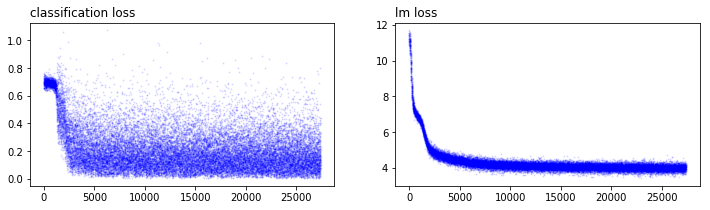

In [0]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(1, 2, 1)
plt.plot(clf_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('classification loss', fontsize=12, loc='left')
ax = fig.add_subplot(1, 2, 2)
plt.plot(lm_losses, 'o', color='b', ms=1, alpha=0.1)
plt.title('lm loss', fontsize=12, loc='left');

#### Encode eval data

In [19]:
val_seqs = encode(val_texts,
                  val_labels,
                  tokenizer,
                  MAX_LEN,
                  SPECIAL_TOKENS)

val_ds = TensorDataset(*val_seqs)
val_sampler = SequentialSampler(val_ds)

val_loader = DataLoader(val_ds,
                        sampler=val_sampler,
                        batch_size=BATCH_SIZE)

100%|██████████| 2687/2687 [00:02<00:00, 918.34it/s]


#### Load trained model
Skip this step if training and evaluating in the same runtime.

In [0]:
SAVED_MODEL_FNAME = 'gpt_pytorch.bin'
SAVED_MODEL_DIR = '/content/saved_models'
model.load_state_dict(torch.load(os.path.join(SAVED_MODEL_DIR, SAVED_MODEL_FNAME)))
logger1.info(f'Model loaded from {SAVED_MODEL_DIR + "/" + SAVED_MODEL_FNAME}')

#### Generate eval set predictions

In [21]:
model = model.to(device)

model.eval()

val_logits = []
val_preds = []

tq = tqdm(enumerate(val_loader), total=len(val_loader), mininterval=10)
for i, batch in tq:
    input_ids, mc_token_ids, _, _ = batch

    _, mc_logits_batch = model(input_ids.to(device),
                               mc_token_ids.to(device))
    
    preds_batch = torch.sigmoid(mc_logits_batch).to(device)
    preds_batch = preds_batch.detach().cpu().squeeze().tolist()
    
    val_preds.extend(preds_batch)


100%|██████████| 168/168 [00:15<00:00, 10.55it/s]


In [0]:
val_df = pd.concat([val_df, pd.Series(val_preds, index=val_df.index, name='pred')], axis=1)

id_ref_cols_bool = [col + '_bool' for col in id_ref_cols]
for col in id_ref_cols:
    val_df[col+'_bool'] = (val_df[col] >= 0.5)
val_df['target_bool'] = val_df.target_int.astype('bool')

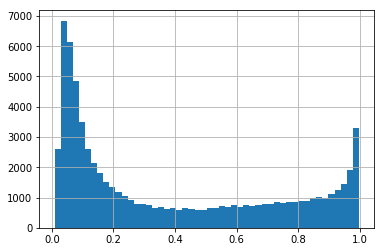

In [0]:
plt.hist(val_preds, bins=50);

#### Validation metrics

In [0]:
val_preds = np.array(val_preds)
val_AUC = metrics.roc_auc_score(val_labels, val_preds)
val_acc = metrics.accuracy_score(val_labels.astype('int'), val_preds.astype('int'))
logger1.info(f'Eval set AUC = {val_AUC:.4f}')
logger1.info(f'Eval set accuracy = {val_acc:.4f}')
print(f'AUC {val_AUC:.4f}, acc {val_acc:.4f}')